In [ ]:
!pip install graphviz

In [ ]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None


  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward
    return out
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out
  def __rmul__(self,other):
    return self * other
  def __truediv__(self, other):
    return self * other**-1
  def __sub__(self, other):
    """Implements a subtraction operation."""

    return self + (-other)
  def __rsub__(self, other):
   """Implements a reversal subtraction operation"""

   return self + (-other)
  def __neg__(self):
   return self * -1
  def __sub__(self, other):
    return self + (-other)
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

In [ ]:
a = Value(3.0, label='a')
b = Value(2.0, label='b')
c = Value(5.0, label='c')
f = a + b
f.label = 'f'
e = f * c
e.label = 'e'
e

Value(data=25.0)

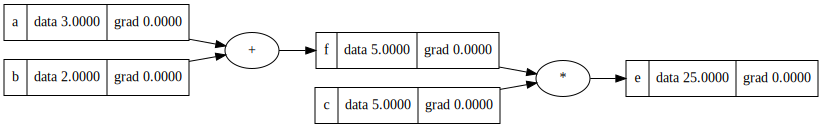

In [ ]:
draw_dot(e)

In [ ]:
e.backward()

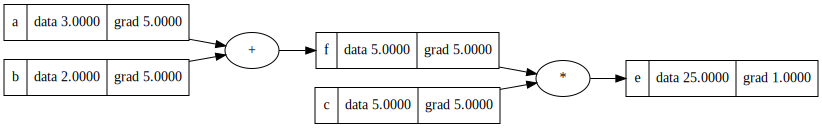

In [ ]:
draw_dot(e)

In [ ]:
# Building a Neuron
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]

In [ ]:
# Building a Layer
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [ ]:
# Building a network out of Layers (Multi Layered Perceptron)
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for neuron in layer.neurons for p in neuron.w + [neuron.b]]

In [ ]:
xs = [
    [4.0, 2.0, -1.0, 3.0],
    [-1.0, -1.0, 2.5, 2.0],
    [3.5, 4.0, 1.0, -1.5],
    [1.0, -1.0, -2.0, 3.0],
]
ys = [1.0, -1.0, 1.0, -1.0]

mlp = MLP(4, [1])

ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.5995847616984319),
 Value(data=-0.2636148045712094),
 Value(data=-0.5823200147672021),
 Value(data=0.8900918654817813)]

In [ ]:
for k in range(300):
  ypred = [mlp(x) for x in xs]
  loss = sum(((ypred[i] - ys[i])**2 for i in range(len(ys))), start=Value(0))

  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()

  for p in mlp.parameters():
    p.data -= 0.05 * p.grad

  print(f"Iteration number : {k+1} ", f"error : {loss.data}")

Iteration number : 1  error : 6.778779408204079
Iteration number : 2  error : 1.8787483163657008
Iteration number : 3  error : 0.03542851325769208
Iteration number : 4  error : 0.027164522679221863
Iteration number : 5  error : 0.023914668330692355
Iteration number : 6  error : 0.021904929598067956
Iteration number : 7  error : 0.020401744320066945
Iteration number : 8  error : 0.019169776055982836
Iteration number : 9  error : 0.018112033615035897
Iteration number : 10  error : 0.017180488844551308
Iteration number : 11  error : 0.016347519583477695
Iteration number : 12  error : 0.015595221370878317
Iteration number : 13  error : 0.014910898485756368
Iteration number : 14  error : 0.014284956355762074
Iteration number : 15  error : 0.013709818998984782
Iteration number : 16  error : 0.013179321664491293
Iteration number : 17  error : 0.012688341418790423
Iteration number : 18  error : 0.012232556004002765
Iteration number : 19  error : 0.011808276882558685
Iteration number : 20  erro

In [ ]:
ypred

[Value(data=0.9797912388315542),
 Value(data=-0.9917054123316839),
 Value(data=0.9999980389629007),
 Value(data=-0.9752313326509442)]

In [ ]:
ys

[1.0, -1.0, 1.0, -1.0]

Now we can see that the predictions of Y are very close to the actual values of Y, off by a very small margin which can be decreased as further iterations of gradient descent are run